In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import numpy as np


In [39]:
# 数据预处理
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
# 定义要使用的类别
selected_classes = [0, 1, 2]  # 0: 飞机, 1: 鸟, 2: 车

In [47]:
# 加载重新保存的训练集和测试集
train_dataset = torch.load('new_train_dataset.pt')
test_dataset = torch.load('new_test_dataset.pt')

# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


C:\Users\bozhe\AppData\Local\Temp\ipykernel_17936\246117972.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load('new_train_dataset.pt')
C:\Users\b

In [32]:
# 加载STL-10数据集
train_dataset = torchvision.datasets.STL10(root='./data', split='train', transform=transform_train, download=True)
test_dataset = torchvision.datasets.STL10(root='./data', split='test', transform=transform_test, download=True)
# 划分数据集（假设这里将训练集按80%、20%划分为训练集、验证集）
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [46]:
# 模型构建
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [48]:
# 训练模型
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)

        # 在测试集上评估模型
        model.eval()
        test_loss = 0.0
        test_preds = []
        test_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        test_epoch_loss = test_loss / len(test_loader)
        test_accuracy = accuracy_score(test_labels, test_preds)
        test_recall = recall_score(test_labels, test_preds, average='macro')
        test_f1 = f1_score(test_labels, test_preds, average='macro')

        print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Test Loss: {test_epoch_loss:.4f} - Test Accuracy: {test_accuracy:.4f} - Test Recall: {test_recall:.4f} - Test F1: {test_f1:.4f}')

    return model


In [49]:
# 训练模型
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer)

# 在测试集上再次评估模型以获取最终结果
test_model = trained_model
test_model.eval()
test_loss = 0.0
test_preds = []
test_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
        outputs = test_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_epoch_loss = test_loss / len(test_loader)
test_accuracy = accuracy_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds, average='macro')
test_f1 = f1_score(test_labels, test_preds, average='macro')

print(f'Final Test Loss: {test_epoch_loss:.4f} - Final Test Accuracy: {test_accuracy:.4f} - Final Test Recall: {test_recall:.4f} - Final Test F1: {test_f1:.4f}')


Epoch 1/10 - Train Loss: 0.9197 - Test Loss: 0.5555 - Test Accuracy: 0.7600 - Test Recall: 0.7630 - Test F1: 0.7618
Epoch 2/10 - Train Loss: 0.5238 - Test Loss: 0.4915 - Test Accuracy: 0.8267 - Test Recall: 0.8244 - Test F1: 0.8248
Epoch 3/10 - Train Loss: 0.3809 - Test Loss: 0.4575 - Test Accuracy: 0.8533 - Test Recall: 0.8507 - Test F1: 0.8518
Epoch 4/10 - Train Loss: 0.2469 - Test Loss: 0.5077 - Test Accuracy: 0.8133 - Test Recall: 0.8164 - Test F1: 0.8129
Epoch 5/10 - Train Loss: 0.1927 - Test Loss: 0.4751 - Test Accuracy: 0.8533 - Test Recall: 0.8527 - Test F1: 0.8526
Epoch 6/10 - Train Loss: 0.0731 - Test Loss: 0.6693 - Test Accuracy: 0.8433 - Test Recall: 0.8402 - Test F1: 0.8416
Epoch 7/10 - Train Loss: 0.0525 - Test Loss: 0.5126 - Test Accuracy: 0.8600 - Test Recall: 0.8559 - Test F1: 0.8576
Epoch 8/10 - Train Loss: 0.0222 - Test Loss: 0.6349 - Test Accuracy: 0.8700 - Test Recall: 0.8700 - Test F1: 0.8699
Epoch 9/10 - Train Loss: 0.0076 - Test Loss: 0.7136 - Test Accuracy: 0.8

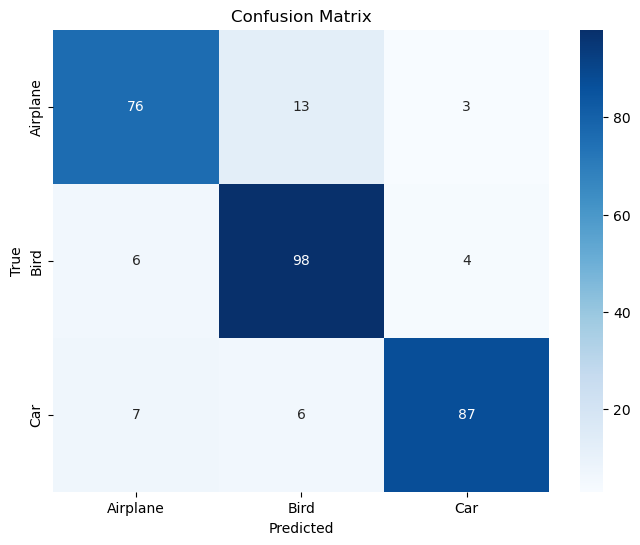

In [56]:
# 生成混淆矩阵
confusion_mat = confusion_matrix(test_labels, test_preds)
class_names = ['Airplane', 'Bird', 'Car']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [4]:
chinese_data = [
    ["准确率", "0.8700"],
    ["召回率", "0.8678"],
    ["F1值", "0.8693"]
]

# 打印结果
for row in chinese_data:
    print("|".join(row))

最终测试损失|0.7801
最终测试准确率|0.8700
最终测试召回率|0.8678
最终测试F1值|0.8693
